In [1]:
import ipywidgets as widgets

path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='File path:',
    disabled=False
)

display(path)


Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='File path:', placeho…

In [14]:
%matplotlib inline
import vtk
from vtk.numpy_interface import dataset_adapter as dsa
from scipy.optimize import minimize
from scipy.spatial import distance
import ipyvolume as ipv
import numpy as np
from skimage import io


reader = vtk.vtkSTLReader()
reader.SetFileName(path.value)
reader.Update()


In [15]:
mesh = dsa.WrapDataObject(reader.GetOutput())

pt_cloud = mesh.GetPoints()
#ipv.quickscatter(pt_cloud[:,0], pt_cloud[:,1], pt_cloud[:,2], size=1, marker="sphere")

In [16]:
z_l,z_u = mesh.GetBounds()[4:6]
center = mesh.GetCenter()

print(mesh.GetBounds())

z = z_u - z_l +2 

(-3.028820037841797, 3.028820037841797, -3.0498499870300293, 3.0498499870300293, -0.9990889430046082, 0.9990889430046082)


In [17]:

def opt_cyl(c,z,z_l,X,r):
    ray = np.array([[c[0]-c[2],c[1]-c[3],z]])
    X_v = X - np.array([c[2],c[3],z_l])
    dist_ar = distance.cdist(ray,X)
    diff = np.abs(dist_ar-r)
    return np.mean(diff)

x_0 = np.array([center[0],center[1],center[0],center[1]])
bd = ((mesh.GetBounds()[0:2]),(mesh.GetBounds()[2:4]),(mesh.GetBounds()[0:2]),(mesh.GetBounds()[2:4]))
result = minimize(opt_cyl,x_0,args=(z,z_l,pt_cloud,5.8/2),bounds = bd)


In [18]:
from numpy import linalg as la

top = np.array([result.x[0],result.x[1],z_u])
rotation_ori = np.array([result.x[2],result.x[3],z_l])

ray = top-rotation_ori
vert = np.array([center[0],center[1],1])

angle = np.arccos(np.vdot(ray,vert)/(la.norm(ray)*la.norm(vert)))
rotate = vtk.vtkTransform()
rotate.RotateWXYZ(np.rad2deg(angle),rotation_ori)

transform_filter = vtk.vtkTransformPolyDataFilter()
transform_filter.SetInputConnection(reader.GetOutputPort())
transform_filter.SetTransform(rotate)
transform_filter.Update()

rotated_mesh = dsa.WrapDataObject(transform_filter.GetOutput())
pt_cloud = mesh.GetPoints()
#ipv.quickscatter(pt_cloud[:,0], pt_cloud[:,1], pt_cloud[:,2], size=1, marker="sphere")

cyl_to_cartesian = vtk.vtkCylindricalTransform()
cartesian_to_cyl = cyl_to_cartesian.GetInverse()

coord_transform = vtk.vtkTransformPolyDataFilter()
coord_transform.SetTransform(cartesian_to_cyl)
coord_transform.SetInputConnection(transform_filter.GetOutputPort())
coord_transform.Update()


In [19]:
mesh_cyl = dsa.WrapDataObject(coord_transform.GetOutput())

print(mesh_cyl.GetBounds())

pt_cloud_cyl = mesh_cyl.GetPoints()


(2.862773895263672, 3.074152708053589, 4.076118420925923e-05, 6.283185005187988, -1.0047898292541504, 1.0047720670700073)


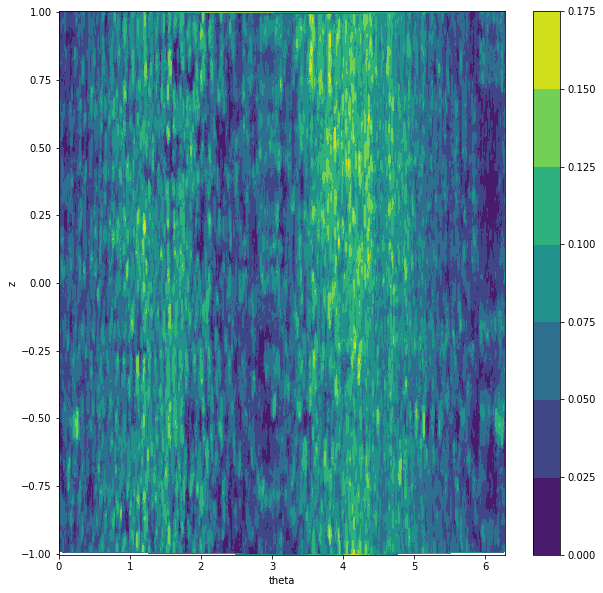

In [22]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

norm_pt_cloud = np.copy(pt_cloud_cyl)
norm_pt_cloud[:,0] = np.abs(norm_pt_cloud[:,0] - 5.8/2)

triang = tri.Triangulation(norm_pt_cloud[:,1], norm_pt_cloud[:,2])
fig, ax = plt.subplots(figsize=(10, 10))
tcf = ax.tricontourf(triang, norm_pt_cloud[:,0])
fig.colorbar(tcf)
ax.set_xlabel("theta")
ax.set_ylabel("z")
plt.show()

In [23]:
import numpy.ma as ma

norm_pt_cloud_na = np.copy(pt_cloud_cyl)
norm_pt_cloud_na[:,0] = norm_pt_cloud_na[:,0] - 5.8/2

z_res = 100
theta_res = 300
r_res = 5

r_delta_max = np.max(norm_pt_cloud_na[:,0])
r_delta_min = np.min(norm_pt_cloud_na[:,0])
zz = np.linspace(-1.00,1.00,z_res)

triang = tri.Triangulation(norm_pt_cloud_na[:,1], norm_pt_cloud_na[:,2])
interpolator = tri.LinearTriInterpolator(triang, norm_pt_cloud_na[:,0])
Xi, Yi = np.meshgrid(np.linspace(0,2*np.pi,theta_res), zz)
r = interpolator(Xi, Yi)
dist = np.zeros((z_res,r_res))

for i in range(z_res):
    bined, bin_edge=np.histogram(r[i,:],bins=r_res,range=(r_delta_min,r_delta_max))
    dist[i] = bined

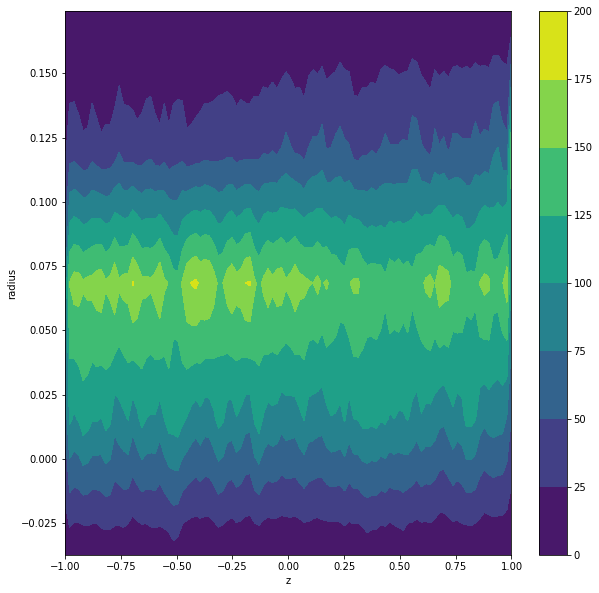

In [24]:
fig,ax = plt.subplots(figsize=(10,10))
Zi,bini = np.meshgrid(zz,np.linspace(r_delta_min,r_delta_max,r_res))
cf = ax.contourf(Zi,bini,dist.T)
fig.colorbar(cf)
ax.set_xlabel("z")
ax.set_ylabel("radius")
plt.show()
